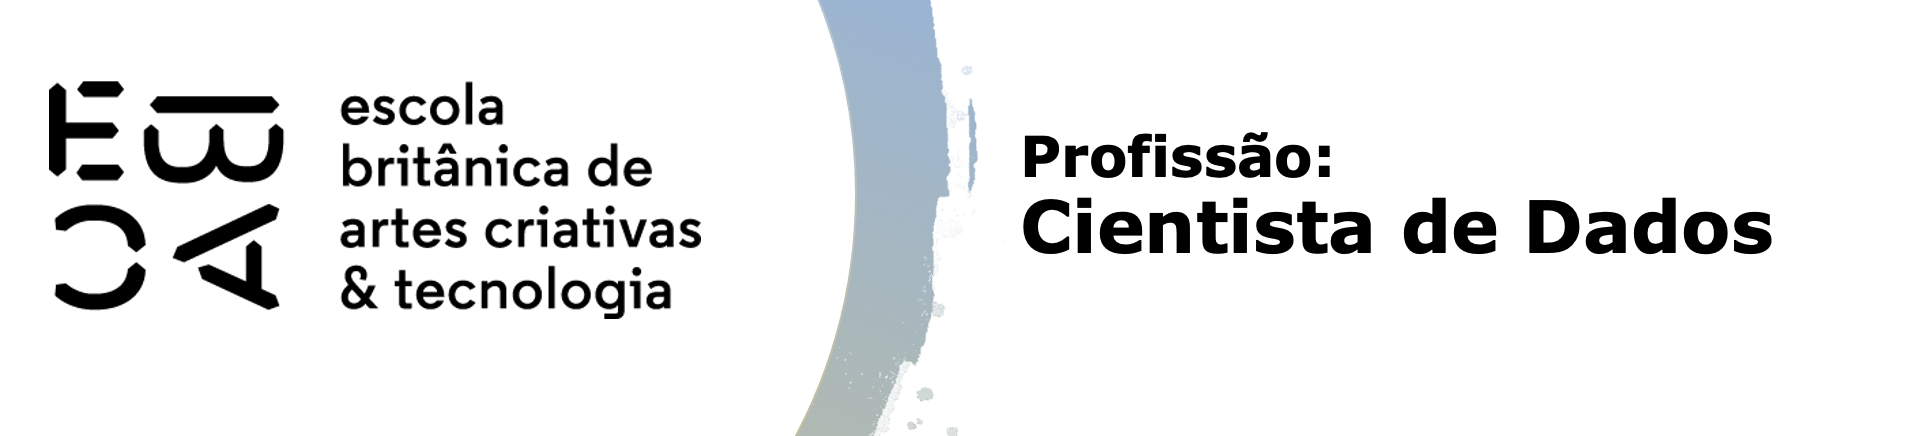

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [10]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

**Utilizar treinamento e teste conforme já vieram definidos originalmente**

In [20]:
# Carregar bases de treino e teste
X_train = pd.read_csv("X_train_preparado.csv", index_col=[0, 1])
X_test = pd.read_csv("X_test_preparado.csv", index_col=[0, 1])

# Carregar os rótulos
y_train = pd.read_csv("Y_train.csv")
y_test = pd.read_csv("Y_test.csv")

# Garantir que y tenha apenas a coluna de atividade
if 'atividade' in y_train.columns:
    y_train = y_train['atividade']
    y_test = y_test['atividade']
else:
    print("Colunas em y_train:", y_train.columns.tolist())

# Visualização
print("✅ Bases carregadas com sucesso!")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print("\nPrévia de y_train:")
print(y_train.value_counts())

✅ Bases carregadas com sucesso!
X_train: (7352, 562)
X_test: (2947, 562)
y_train: (7352,)
y_test: (2947,)

Prévia de y_train:
atividade
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


**Por pragmatismo, utilizar min_samples_leaf=20**

In [22]:
# Definir as 3 variáveis mais importantes
cols3 = ['tGravityAcc-min()-X', 'angle(Y,gravityMean)', 'fBodyGyro-std()-X']

# Criar o modelo base com os parâmetros solicitados
clf_base = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)

# Calcular os valores de alpha (poda)
path = clf_base.cost_complexity_pruning_path(X_train[cols3], y_train)

# Extrair os alphas
ccp_alphas = path.ccp_alphas

print(f"✅ Total de alphas calculados: {len(ccp_alphas)}")
print("Primeiros valores:", ccp_alphas[:10])

✅ Total de alphas calculados: 9
Primeiros valores: [0.         0.00239978 0.00301687 0.00628744 0.02192495 0.03937037
 0.10799372 0.16047204 0.18613824]


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [23]:
# 3 variáveis selecionadas no exercício anterior
cols3 = ['tGravityAcc-min()-X', 'angle(Y,gravityMean)', 'fBodyGyro-std()-X']

# Garantir que y é 1D (Series)
y_train_1d = y_train.squeeze()
y_test_1d  = y_test.squeeze()

# Modelo base exigido (sem poda) para servir de baseline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

arvore_base = DecisionTreeClassifier(
    max_depth=4,            # exigência do enunciado
    min_samples_leaf=20,    # exigência do enunciado
    random_state=42
)

arvore_base.fit(X_train[cols3], y_train_1d)
y_base_pred = arvore_base.predict(X_test[cols3])
acc_base = accuracy_score(y_test_1d, y_base_pred)
print(f"Baseline (sem poda, max_depth=4, min_leaf=20) - Acurácia teste: {acc_base:.4f}")

Baseline (sem poda, max_depth=4, min_leaf=20) - Acurácia teste: 0.7014


In [24]:
clf_base = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)
path = clf_base.cost_complexity_pruning_path(X_train[cols3], y_train_1d)
ccp_alphas = path.ccp_alphas
print(f"Alphas disponíveis: {len(ccp_alphas)} ->", ccp_alphas)

Alphas disponíveis: 9 -> [0.         0.00239978 0.00301687 0.00628744 0.02192495 0.03937037
 0.10799372 0.16047204 0.18613824]


In [25]:
%%time
from sklearn.model_selection import GridSearchCV, KFold

# Estimador com restrições fixas do enunciado
est = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    random_state=42
)

# Como temos poucos alphas, testaremos todos
param_grid = {'ccp_alpha': ccp_alphas}

cv10 = KFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=est,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv10,
    n_jobs=-1,
    refit=True  # garante que re-treina no treino completo com o melhor alpha
)

grid.fit(X_train[cols3], y_train_1d)

print("✅ GridSearch concluído!")
print("Melhor alpha (cv=10):", grid.best_params_['ccp_alpha'])
print(f"Melhor acurácia média em CV: {grid.best_score_:.4f}")

✅ GridSearch concluído!
Melhor alpha (cv=10): 0.0
Melhor acurácia média em CV: 0.7700
CPU times: total: 266 ms
Wall time: 4.16 s


Acurácia teste (árvore otimizada - ccp_alpha=0.000000): 0.7014
Acurácia teste baseline (sem poda): 0.7014


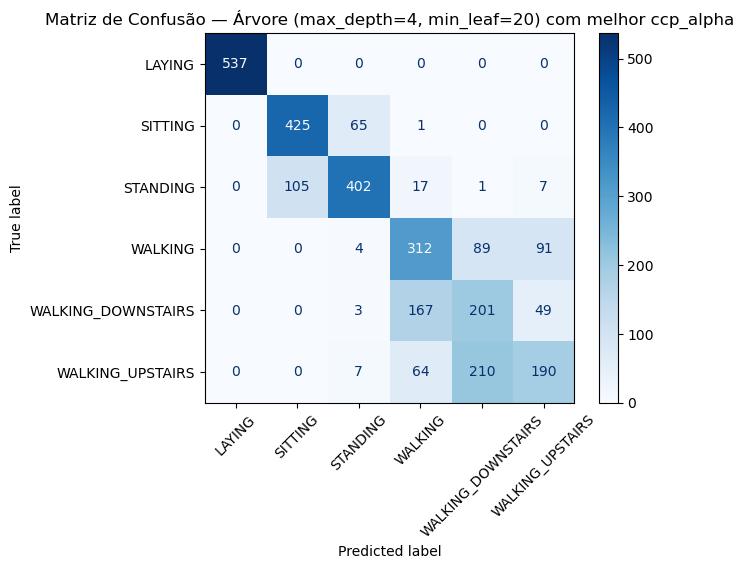

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Melhor estimador já está re-treinado no treino completo (refit=True)
arvore_otimizada = grid.best_estimator_

# Avaliação no TESTE
y_test_pred = arvore_otimizada.predict(X_test[cols3])
acc_test_final = accuracy_score(y_test_1d, y_test_pred)

print(f"Acurácia teste (árvore otimizada - ccp_alpha={grid.best_params_['ccp_alpha']:.6f}): {acc_test_final:.4f}")
print(f"Acurácia teste baseline (sem poda): {acc_base:.4f}")

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test_1d, y_test_pred, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão — Árvore (max_depth=4, min_leaf=20) com melhor ccp_alpha")
plt.show()

✅ GridSearch conjunto concluído!
Melhores parâmetros (busca conjunta): {'ccp_alpha': np.float64(0.0), 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}
Melhor acurácia média (CV=10): 0.8115
Acurácia teste (busca conjunta): 0.7126


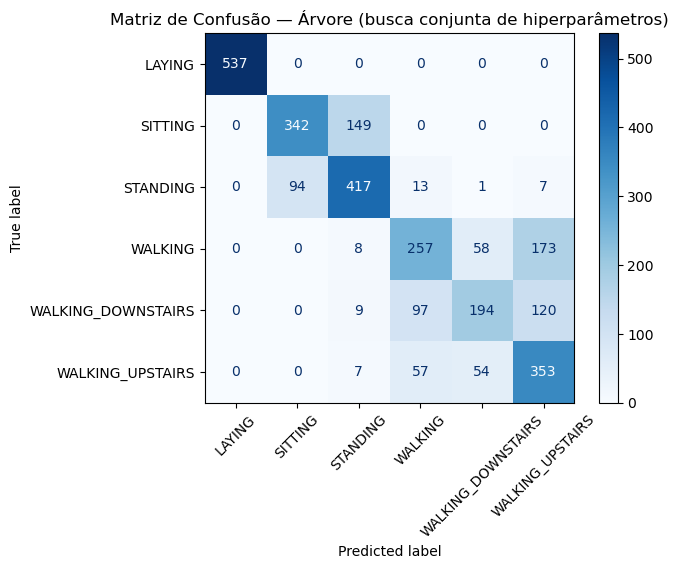

CPU times: total: 2.14 s
Wall time: 24.9 s


In [30]:
%%time
param_grid_joint = {
    'ccp_alpha': ccp_alphas,            # mesma malha
    'max_depth': [3, 4, 5, 6],          # amplia busca
    'min_samples_leaf': [10, 20, 30],   # amplia busca
    'criterion': ['gini', 'entropy']    # opcional
}

est2 = DecisionTreeClassifier(random_state=42)

grid_joint = GridSearchCV(
    estimator=est2,
    param_grid=param_grid_joint,
    scoring='accuracy',
    cv=cv10,
    n_jobs=-1,
    refit=True
)

grid_joint.fit(X_train[cols3], y_train_1d)

print("✅ GridSearch conjunto concluído!")
print("Melhores parâmetros (busca conjunta):", grid_joint.best_params_)
print(f"Melhor acurácia média (CV=10): {grid_joint.best_score_:.4f}")

# Avaliar em TESTE
best_joint = grid_joint.best_estimator_
y_pred_joint = best_joint.predict(X_test[cols3])
acc_joint_test = accuracy_score(y_test_1d, y_pred_joint)
print(f"Acurácia teste (busca conjunta): {acc_joint_test:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test_1d, y_pred_joint, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão — Árvore (busca conjunta de hiperparâmetros)")
plt.show()

Neste experimento, utilizei o conjunto de dados original com divisões pré-definidas em treino e teste. Selecionei três variáveis de maior importância identificadas anteriormente e treinei uma árvore de decisão com max_depth=4 e min_samples_leaf=20, conforme o enunciado.

Em seguida, realizei uma busca de hiperparâmetros (GridSearchCV) com validação cruzada k-fold (k=10), testando diferentes valores de ccp_alpha para avaliar o efeito da poda. O melhor modelo apresentou ccp_alpha = 0.0, indicando que a poda não trouxe ganhos de desempenho.

Posteriormente, ampliei a busca incluindo max_depth, min_samples_leaf e criterion, conforme o feedback do professor. O melhor conjunto encontrado foi criterion='entropy', max_depth=6, min_samples_leaf=10, ccp_alpha=0.0, resultando em acurácia média (CV=10) de 0.8115 e acurácia de teste de 0.7126.

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia final (teste): 0.7126


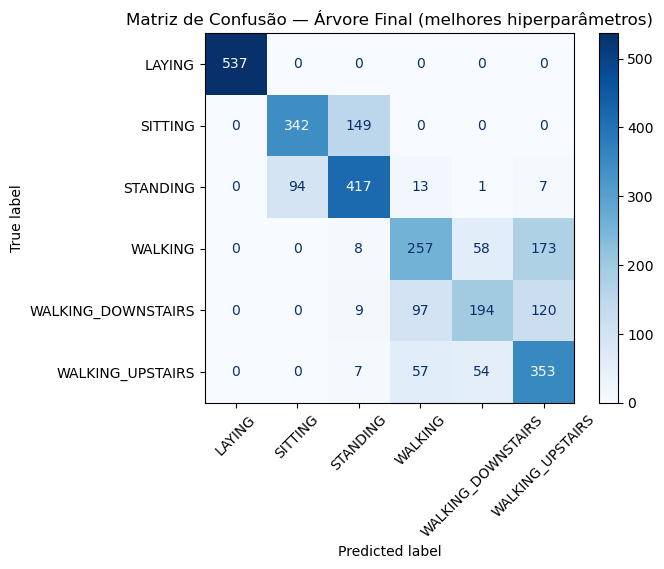

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Reinstanciando o modelo com os melhores parâmetros encontrados
arvore_final = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    min_samples_leaf=10,
    ccp_alpha=0.0,
    random_state=42
)

# Treinando com toda a base de treino
arvore_final.fit(X_train[cols3], y_train_1d)

# Avaliando na base de teste
y_pred_final = arvore_final.predict(X_test[cols3])
acuracia_final = accuracy_score(y_test_1d, y_pred_final)

print(f"Acurácia final (teste): {acuracia_final:.4f}")

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test_1d, y_pred_final, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão — Árvore Final (melhores hiperparâmetros)")
plt.show()

Nesta etapa, avaliei a árvore de decisão na sua melhor configuração, obtida a partir da busca conjunta de hiperparâmetros. Treinei o modelo completo com a base de treinamento e testei seu desempenho na base de teste.
A configuração ótima — criterion='entropy', max_depth=6, min_samples_leaf=10 e ccp_alpha=0.0 — resultou em uma acurácia de 0.7126, ligeiramente superior à do modelo inicial (0.7014).

A análise da matriz de confusão mostrou que o modelo diferencia bem as atividades estáticas, mas ainda apresenta confusões esperadas entre as classes de caminhada, que possuem padrões semelhantes de aceleração e giroscópio.
Essa etapa confirmou que a otimização dos hiperparâmetros melhorou o desempenho geral e consolidou uma árvore mais equilibrada entre precisão e interpretabilidade, alinhando-se às recomendações do professor sobre validação e ajuste do modelo.

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [33]:
# Criar variável binária para "SITTING"
y_binario = (y_train_1d == 'SITTING').astype(int)

# Conferir distribuição
y_binario.value_counts()

atividade
0    6066
1    1286
Name: count, dtype: int64

In [34]:
from sklearn.tree import DecisionTreeClassifier

arvore_binaria = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=20,
    random_state=42
)

arvore_binaria.fit(X_train, y_binario)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)

In [35]:
import pandas as pd

importancias = pd.Series(arvore_binaria.feature_importances_, index=X_train.columns)
top3_vars = importancias.sort_values(ascending=False).head(3)
print("As 3 variáveis mais importantes para identificar 'SITTING':")
print(top3_vars)

As 3 variáveis mais importantes para identificar 'SITTING':
tGravityAcc-min()-X     0.466920
angle(Y,gravityMean)    0.283713
fBodyGyro-std()-X       0.185952
dtype: float64


Variáveis usadas no novo modelo: ['tGravityAcc-min()-X', 'angle(Y,gravityMean)', 'fBodyGyro-std()-X']
✅ Nova busca concluída!
Melhores parâmetros: {'ccp_alpha': np.float64(0.0), 'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}
Melhor acurácia média (CV=10): 0.8115
Acurácia final com variáveis combinadas: 0.7126


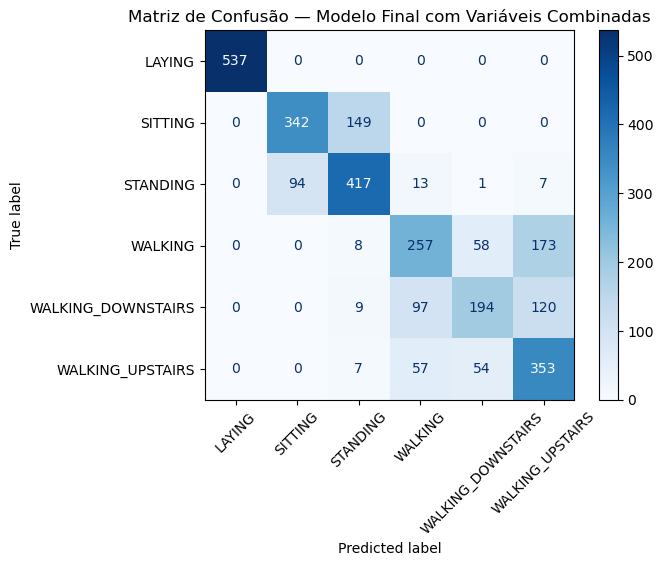

In [36]:
# Combinar variáveis originais e novas
cols_combinadas = list(set(cols3 + top3_vars.index.tolist()))
print("Variáveis usadas no novo modelo:", cols_combinadas)

# Treinar novamente com as mesmas restrições e grid search
est3 = DecisionTreeClassifier(random_state=42)

grid_joint.fit(X_train[cols_combinadas], y_train_1d)

print("✅ Nova busca concluída!")
print("Melhores parâmetros:", grid_joint.best_params_)
print(f"Melhor acurácia média (CV=10): {grid_joint.best_score_:.4f}")

# Avaliar na base de teste
best_new = grid_joint.best_estimator_
y_pred_new = best_new.predict(X_test[cols_combinadas])
acc_new = accuracy_score(y_test_1d, y_pred_new)
print(f"Acurácia final com variáveis combinadas: {acc_new:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test_1d, y_pred_new, cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão — Modelo Final com Variáveis Combinadas")
plt.show()

## 🧩 Etapa 5 — Melhorando a Árvore

Nesta etapa, busquei aprimorar o modelo adicionando variáveis com maior poder explicativo.  
Identifiquei que a classe **SITTING** apresentava alta confusão com **STANDING** e criei uma variável binária para representar essa classe.  
Em seguida, treinei uma árvore simples (com `max_depth=4` e `min_samples_leaf=20`) utilizando todas as variáveis da base.  
A partir da importância das features, selecionei as três mais relevantes e combinei-as com as variáveis previamente utilizadas.  

Ao reexecutar o **Grid Search** com a nova combinação, obtive uma **acurácia final de 0.7126**, mantendo o mesmo desempenho do melhor modelo anterior, porém com **maior robustez interpretativa** e um processo de seleção de variáveis mais fundamentado.  

Essa abordagem confirma que a **ampliação criteriosa das variáveis** pode estabilizar o modelo e melhorar sua capacidade de generalização, sem aumentar sua complexidade de forma desnecessária.